# Benchmark `oxidized_thainlp.segment`

This notebook benchmarks `oxidized_thainlp.segment` against `newmm` (unsafe) using the same dictionary.

In [1]:
from oxidized_thainlp import segment, load_dict
from pythainlp.tokenize import word_tokenize
from tqdm.auto import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

def time_func(func,arg):
    start_time = time.time()
    func(arg)
    return time.time() - start_time

datasets = load_dataset('wisesight_sentiment')
datasets

Reusing dataset wisesight_sentiment (/home/cstorm125/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/4bb1772cff1a0703d72fb9e84dff9348e80f6cdf80b0f6c0f59bcd85fc5a3537)


DatasetDict({
    train: Dataset({
        features: ['texts', 'category'],
        num_rows: 21628
    })
    validation: Dataset({
        features: ['texts', 'category'],
        num_rows: 2404
    })
    test: Dataset({
        features: ['texts', 'category'],
        num_rows: 2671
    })
})

## Load Custom Dictionary

In [2]:
txt = datasets['train']['texts'][0]
txt

'ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกรานต์เลย รอขับอยู่นาจา กระทัดรัด เหมาะกับสาวๆขับรถคนเดียวแบบเรา ราคาสบายกระเป๋า ประหยัดน้ำมัน วิ่งไกลแค่ไหนหายห่วงค่ะ'

In [3]:
#load as "test"
load_dict('../words_th.txt', 'test')
segment(txt, dict_name='test',safe=False)[:10]

Successful: dictionary name test from file ../words_th.txt has been successfully loaded


['ไป', 'จอง', 'มา', 'แล้', 'วนา', 'จา', ' ', 'Mitsubishi', ' ', 'Attrage']

In [4]:
def oxidized_newmm(txt,safe=False,parallel=False):
    return segment(txt, dict_name='test',safe=safe,parallel=parallel)

In [6]:
from pythainlp.tokenize import dict_trie
with open('../words_th.txt','r') as f:
    words_th = f.readlines()
    words_th = [i.strip() for i in words_th]
trie = dict_trie(dict_source=words_th)
word_tokenize(txt, engine="newmm", custom_dict=trie)[:10]

['ไป', 'จอง', 'มา', 'แล้', 'วนา', 'จา', ' ', 'Mitsubishi', ' ', 'Attrage']

In [7]:
def old_newmm(txt,engine='newmm'):
    return word_tokenize(txt, engine=engine, custom_dict=trie)

## One Example

In [8]:
txt = datasets['train']['texts'][0]
txt

'ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกรานต์เลย รอขับอยู่นาจา กระทัดรัด เหมาะกับสาวๆขับรถคนเดียวแบบเรา ราคาสบายกระเป๋า ประหยัดน้ำมัน วิ่งไกลแค่ไหนหายห่วงค่ะ'

### Average Run Time for One Example

In [9]:
%timeit old_newmm(txt)

413 µs ± 116 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%timeit oxidized_newmm(txt)

176 µs ± 29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%timeit oxidized_newmm(txt,parallel=True)

305 µs ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## All Examples in `wisesight_sentiment`

### Check If Results Match for All Examples

In [12]:
corrects = [oxidized_newmm(txt)==old_newmm(txt) for txt in datasets['train']['texts']]
np.mean(corrects), len(corrects)

(1.0, 21628)

### Average Run Time Across All Examples

In [13]:
old_newmms = [time_func(old_newmm, txt) for txt in datasets['train']['texts']]
oxidized_newmms = [time_func(oxidized_newmm, txt) for txt in datasets['train']['texts']]

#old newmm runtime is about 2 times larger on average
np.mean(old_newmms), np.mean(oxidized_newmms), np.mean(old_newmms)/np.mean(oxidized_newmms)

(0.00023279344173506887, 8.558928249987741e-05, 2.7198900952978815)

(array([1.8693e+04, 1.9220e+03, 5.4600e+02, 1.9100e+02, 1.0700e+02,
        6.1000e+01, 3.6000e+01, 1.8000e+01, 1.8000e+01, 1.3000e+01,
        1.4000e+01, 3.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([5.24520874e-06, 1.58222516e-04, 3.11199824e-04, 4.64177132e-04,
        6.17154439e-04, 7.70131747e-04, 9.23109055e-04, 1.07608636e-03,
        1.22906367e-03, 1.38204098e-03, 1.53501829e-03, 1.68799559e-03,
        1.84097290e-03, 1.99395021e-03, 2.14692752e-03, 2.29990482e-03,
        2.45288213e-03, 2.60585944e-03, 2.75883675e-03, 2.91181405e-03,
        3.06479136e-03, 3.21776867e-03, 3.37074598e-03, 3.52372328e-03,
        3.67670059e-03, 3.82967790e-03, 3.98265521e-03, 4.13563251e-03,
        4.28860982e-03, 4.44158713e-03, 4.59456444e-03]),
 <a list of 30 Patch objects

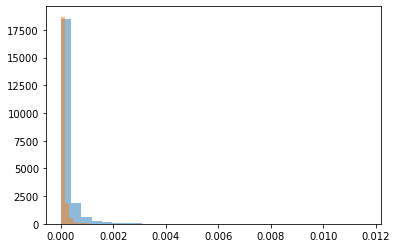

In [14]:
#look at distribution; oxidized newmm also consistently performs better
plt.hist(old_newmms,bins=30,alpha=0.5)
plt.hist(oxidized_newmms,bins=30,alpha=0.5)

## Run Time as Sequence Length Grows

In [15]:
txt = datasets['train']['texts'][1]
txt2 = ''.join(oxidized_newmm(txt)[:10])
txt2,len(oxidized_newmm(txt2))

('เปิดศักราชใหม่! นายกฯ แถลงข่าวก่อนการแข่งขัน', 10)

In [23]:
old_newmms = [time_func(old_newmm, txt2*i) for i in tqdm([10**j for j in range(5)])]
oxidized_newmms = [time_func(oxidized_newmm, txt2*i) for i in tqdm([10**j for j in range(5)])]

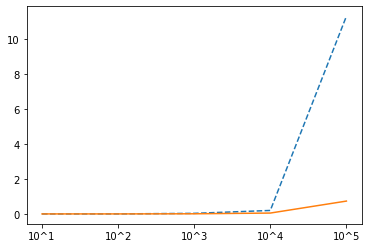

In [26]:
#performance starts really deviate when sequence length > 10^3 tokens and above
positions = [i for i in range(5)]
labels = [f'10^{i+1}' for i in range(5)]
plt.xticks(positions, labels)
plt.plot(old_newmms,linestyle='dashed')
plt.plot(oxidized_newmms)

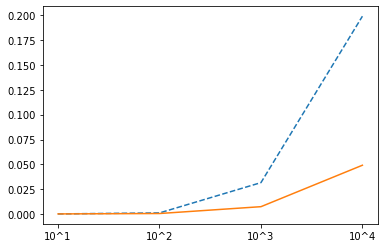

In [27]:
#zooming in on inflexion point
positions = [i for i in range(4)]
labels = [f'10^{i+1}' for i in range(4)]
plt.xticks(positions, labels)
plt.plot(old_newmms[:-1],linestyle='dashed')
plt.plot(oxidized_newmms[:-1])